In [2]:
import pycuda
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

/tmp/ipykernel_500037/1345245070.py:61: RuntimeWarning: overflow encountered in cast
  initial_u0 = np.empty((grid_dim, grid_dim)).astype(np.float32)


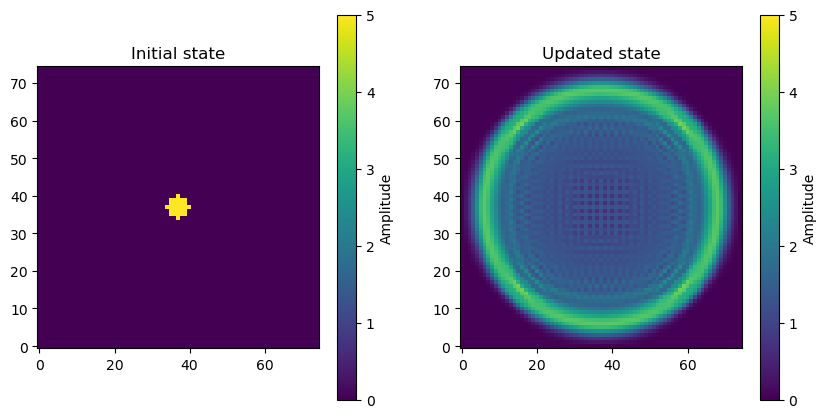

In [9]:
wave_eqn_kernel_src_2D = """
__global__ void waveEqn2D(
            float* u2,
            float* u1, 
            float* u0,
            float c,  // Wave speed
            float dx,
            float dy,
            float dt,
            unsigned int nx,
            unsigned int ny) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    
    // First cell: new 2D boundaries
    if (i == 0 || i == nx - 1 || j == 0 || j == ny - 1) {
        u1[i + j * nx] = u1[i + j * nx];
    }
    // Internal cells
    else if (i < nx - 1 && j < ny - 1) {
        u2[i + j * nx] = 2.0f * u1[i + j * nx] - u0[i + j * nx]
                        + c * dt*dt / (dx * dx) * (u1[(i - 1) + j * nx] - 2 * u1[i + j * nx] + u1[(i + 1) + j * nx]) 
                        + c * dt*dt / (dy * dy) * (u1[i + (j - 1) * nx] - 2 * u1[i + j * nx] + u1[i + (j + 1) * nx]);
    }
}
"""

mod = SourceModule(wave_eqn_kernel_src_2D)
waveEqnGPU_2d = mod.get_function("waveEqn2D")


def waveEquationGPU2D(u1, u0, c, dt, dx, dy):
    assert(u0.dtype == np.float32)
    
    u2_gpu = cuda.mem_alloc(u0.nbytes)
    u1_gpu = cuda.mem_alloc(u0.nbytes)
    u0_gpu = cuda.mem_alloc(u0.nbytes)
    cuda.memcpy_htod(u0_gpu, u0)
    cuda.memcpy_htod(u1_gpu, u1)
    
    nx, ny = u0.shape
    block = (256, 1, 1)
    grid = (int(np.ceil(nx / block[0])), int(np.ceil(ny / block[1])), 1)
    
    waveEqnGPU_2d(u2_gpu, u1_gpu, u0_gpu, np.float32(c), np.float32(dx), np.float32(dy), np.float32(dt), np.uint32(nx), np.uint32(ny), block=block, grid=grid)
    
    u0_gpu, u1_gpu, u2_gpu = u1_gpu, u2_gpu, u0_gpu

    u2 = np.empty_like(u0)
    cuda.memcpy_dtoh(u2, u2_gpu)
    cuda.memcpy_dtoh(u1, u1_gpu)
    cuda.memcpy_dtoh(u0, u0_gpu)
    
    return u2

#__________________________________________________________________________________

# Set grids for u0 and u1
grid_dim = 75
grid_temp = 0.0
initial_u0 = np.empty((grid_dim, grid_dim)).astype(np.float32)
initial_u0.fill(grid_temp)
initial_u1 = initial_u0.copy()

# Set initial values
findCenter = grid_dim // 2
for i in range(grid_dim):
    for j in range(grid_dim):
        center_dist = np.sqrt((i - findCenter)**2 + (j - findCenter)**2)
        if center_dist <= 3:
            initial_u1[i, j] = 5.0

# Initializing u0, u1 with initial conditions
u0 = initial_u0.copy()
u1 = initial_u1.copy()

c = 10.0
dx = 10.0
dy = 10.0
dt = 0.4*min(dx**2 / (2.0*c), dy**2 / (2.0*c))

#Creating two figures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First plot settings
im1 = ax1.imshow(initial_u1, cmap='viridis', origin='lower', interpolation='none')
ax1.set_title("Initial state")
plt.colorbar(im1, ax=ax1, label="Amplitude")

# Fuction to create the animation
def update(frame):
    global u1, u0
    u2 = waveEquationGPU2D(u1, u0, c, dt, dx, dy)
    im2.set_array(u2)
    return im2,

# Second plot settings
im2 = ax2.imshow(u1, cmap='viridis', origin='lower', interpolation='none')
ax2.set_title("Updated state")
plt.colorbar(im2, ax=ax2, label="Amplitude")

# Save the animation as .gif
ani = animation.FuncAnimation(fig, update, frames=50, blit=True)
ani.save('wave_equation_animation.gif', writer='pillow')
plt.show()